# Analysis

This notebook is the primary analysis notebook for tau_map6 simulations.

## Notebook Configuration

In [1]:
# import packages
import os
import warnings
from os import PathLike
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

from matplotlib import colormaps
from matplotlib.ticker import MaxNLocator
from matplotlib.animation import FuncAnimation

from rich import print
from tqdm import tqdm

In [2]:
# define the data directory
data_dir = Path("data", "craig_data")

# configure plotting
# define the figure save directory
figure_dir = Path("figures", data_dir.parts[-1])
os.makedirs(figure_dir, exist_ok=True)

# set plot style
cstyle_file_url = r"https://gist.githubusercontent.com/CalvinSprouse/30bba681da1dd0023e948ca207fad0fc/raw/80a1ae94031873a57c9624103e83f5caf175ac86/cstyle.mplstyle"
plt.style.use(["default", cstyle_file_url])

## Import and Process Data

### Define Data Processing Functions

Taken from `data_process_funcs.py`.

In [3]:
# define a function to extract data from a .mat file
def extract_mat_data(mat_file: Path, value_list: list) -> tuple[dict, dict]:
    """
    Extracts variables and arrays from a .mat file.

    Parameters:
    mat_file (Path): The path to the .mat file.
    value_list (list): A list of strings containing the names of the variables and arrays to extract from the .mat file.

    Returns:
    tuple[dict, dict]: A tuple containing two dictionaries: the first dictionary contains the extracted variables, the second dictionary contains the extracted arrays.
    """

    # check that the mat_file exists
    if not mat_file.exists():
        raise FileNotFoundError(f"File '{mat_file}' does not exist.")

    # check that value_list is not empty
    if not value_list:
        raise ValueError("The value_list cannot be empty.")

    # read the .mat file and supress warnings
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        mat_data = sio.loadmat(mat_file, squeeze_me=True)

    # create dictionaries to store extracted data
    var_dict = {}
    array_dict = {}

    # extract variables, check if the extracted variable is a single item, var, or array
    for value in value_list:
        extracted_value = mat_data.get(value)
        if isinstance(extracted_value, np.ndarray):
            array_dict[value] = extracted_value
        else:
            var_dict[value] = extracted_value

    # return the dictionaries
    return var_dict, array_dict


In [4]:
# define a function to extract the sim dictionary from some .mat files
def extract_sim_dict(mat_files: list[PathLike], value_list: list[str], suppress_warnings: bool = True, show_prog: bool = False) -> dict:
    """
    Extracts the simulation dictionary from a directory.

    Parameters:
    mat_files (list[PathLike]): A list of paths to the .mat files.
    value_list (list[str]): A list of strings containing the names of the variables and arrays to extract from the .mat files.
    suppress_warnings (bool): Whether to suppress warnings.
    show_prog (bool): Whether to show progress bars.

    Returns:
    dict: The extracted simulation dictionary.
    """

    # initialize the sim_dict
    # the key of sim_dict shall be the mat_file save_str or the file name
    # the value of sim_dict shall be a dictionary
    # the value shall have one key, "vars", containing the extracted var_dict
    # the value shall have a key for each extracted array whose key name is the array name
    sim_dict = {}

    for mat_file in tqdm(mat_files, desc="Extracting data", unit="file", disable=~show_prog):
        # extract the data
        var_dict, array_dict = extract_mat_data(mat_file, value_list)

        # get the save_str and check that it is not None
        save_str = var_dict["save_str"]
        if save_str is None:
            save_str = mat_file.stem
            if not suppress_warnings:
                print(f"Warning: save_str is None for '{mat_file}'. Using file name, '{save_str}' as save_str.")

        # check that the save str is not already in the dict
        if save_str in sim_dict:
            raise ValueError(f"Duplicate save_str, '{save_str}', found in sim_dict.")

        # create a dictionary to store the extracted data
        sim_dict[save_str] = {
            "vars": var_dict
        }

        # add the extracted arrays to the dictionary
        for array_name, array_data in array_dict.items():
            # check that the array_name is not already in the sim_dict
            if array_name in sim_dict[save_str]:
                raise ValueError(f"Duplicate array name, '{array_name}', found in sim_dict['{save_str}'].")
            sim_dict[save_str][array_name] = array_data

    # return the sim_dict
    return sim_dict


In [5]:
# define a function to create sim_df from extract_sim_dict
def create_sim_df(sim_dict: dict) -> pd.DataFrame:
    """
    Creates a DataFrame from a simulation dictionary.

    Parameters:
    sim_dict (dict): The simulation dictionary.

    Returns:
    pd.DataFrame: The DataFrame containing the simulation data.
    """

    # create a dataframe of each simulations "vars" whose index is the simulation
    sim_df = pd.DataFrame({save_str: sim_data["vars"] for save_str, sim_data in sim_dict.items()}).T
    # remove the save_str column
    sim_df = sim_df.drop(columns=["save_str"])
    # return the sim_df
    return sim_df


In [6]:
def extract_sim_df(mat_files: list[PathLike], value_list: list[str], **kwargs) -> pd.DataFrame:
    """
    Creates a DataFrame from a simulation dictionary.

    Parameters:
    mat_files (list[PathLike]): A list of paths to the .mat files.
    value_list (list[str]): A list of strings containing the names of the variables and arrays to extract from the .mat files.
    **kwargs: Additional keyword arguments to pass to extract_sim_dict.

    Returns:
    pd.DataFrame: The DataFrame containing the simulation data.
    """

    # extract the variables to the sim_dict
    sim_dict = extract_sim_dict(mat_files, value_list, **kwargs)
    # create sim_df
    sim_df = create_sim_df(sim_dict)
    # return the sim_df
    return sim_df


### Extract and Process Data

In [7]:
# define the data directory
# moved to Notebook Configuration
# data_dir = Path("data", "raw_sim_data")

# get the .mat files from data_dir
mat_files = list(data_dir.glob("*.mat"))

In [8]:
# define a list of variables to extract from mat_files
value_list = ["T0", "M0", "taufractip", "taufraclength", "tauplusendasym", "mapfractip", "mapfraclength", "mapplusendasym", "L", "save_str", "MTlength", "MTgrid", "x", "t"]

# convert mat files to sim_dict and sim_df
sim_dict = extract_sim_dict(mat_files, value_list)
sim_df = create_sim_df(sim_dict)

# handle nan values as 0
sim_df = sim_df.fillna(0)

In [9]:
# calculate new column values
# calculate T0/M0
sim_df["T0/M0"] = sim_df["T0"] / sim_df["M0"]

# round the value to one post-decimal place
sim_df["T0/M0"] = sim_df["T0/M0"].round(1)

In [10]:
# create an average df indexed by T0/M0
sim_avg_df = sim_df.groupby("T0/M0").mean()

## Averages DF Plotting

### Define Grouped Bar Plot Function

In [11]:
# define a function to make a grouped bar plot
def grouped_bar_plot(fig, ax,
                     group_data: dict,
                     group_labels: list,
                     colors: list = None,
                     bar_width: float = 0.15,
                     multiplier: float = 0,
                     **kwargs):
    """Plots a grouped bar plot

    Arguments:
        fig -- _description_
        ax -- _description_
        group_data -- _description_

    Keyword Arguments:
        colors -- _description_ (default: {None})
        bar_width -- _description_ (default: {0.2})
        multiplier -- _description_ (default: {0})

    Raises:
        ValueError: _description_

    Returns:
        _description_
    """

    # extract groups from keys of group_data
    group_count = len(group_labels)

    # the default value of colors should be a built in color list
    if colors is None:
        colors = colormaps["tab10"].colors
    else:
        # check if the length of colors is greater than the number of groups
        if len(colors) < group_count:
            raise ValueError("The number of colors provided is less than the number of groups")

    # define the label locations
    x_locations = np.arange(group_count)

    # plot the bars
    for index, (attribute, measurement) in enumerate(group_data.items()):
        # calculate the offset location of each bar
        offset = bar_width * multiplier

        # draw the bar and insert kwargs
        ax.bar(
            x_locations + offset,
            measurement,
            bar_width,
            label=attribute,
            color=colors[index],
            **kwargs
        )

        # iterate the multiplier to space the next bar
        multiplier += 1

    # set the x ticks
    ax.set_xticks(x_locations + bar_width, group_labels)

    return fig, ax

### Plot Binding Rate Ratio vs. MT Length

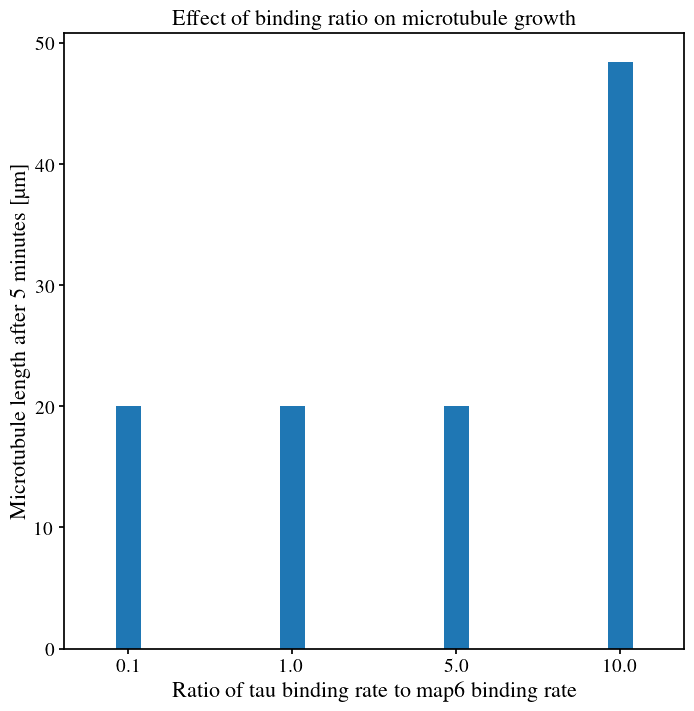

In [12]:
# define the grouped data and group labels
group_data = {"L": sim_avg_df["L"]}
group_labels = sim_avg_df.index

# define the figure
fig, ax = plt.subplots()

# plot the grouped bar plot
fig, ax = grouped_bar_plot(fig, ax, group_data, group_labels, multiplier=1)

# add a margin via xmargin to the x axis
ax.margins(x=0.1)

# set the labels
ax.set_xlabel(r"Ratio of tau binding rate to map6 binding rate")
ax.set_ylabel(r"Microtubule length after 5 minutes [$\qty{}{\micro\meter}$]")
ax.set_title(r"Effect of binding ratio on microtubule growth")

# save the figure
fig.savefig(figure_dir / r"growth_effect")

### Plot Binding Asymmetry

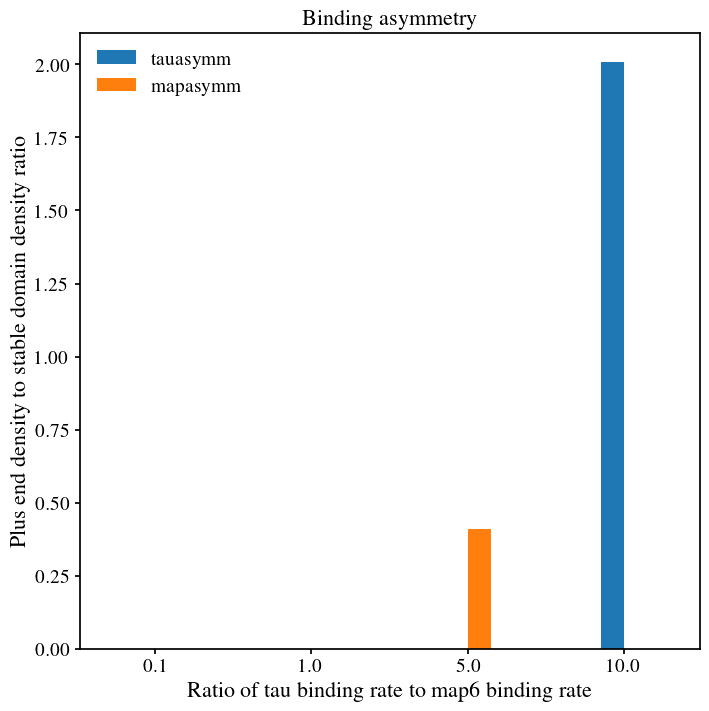

In [13]:
# make a grouped bar plot of binding asymmetry
# on the horizontal: ratio of tau binding rate to map6 binding rate
# on the vertical:
# 1. tau plus end density to stable domain density ratio (tauasymm)
# 2. map6 plus end density to stable domain density ratio (mapasymm)

# define the group data and group labels
group_data = {"tauasymm": sim_avg_df["tauplusendasym"], "mapasymm": sim_avg_df["mapplusendasym"]}
group_labels = sim_avg_df.index

# define the figure
fig, ax = plt.subplots()

# plot the data
fig, ax = grouped_bar_plot(fig, ax, group_data, group_labels, multiplier=1/2)

# add a margin via xmargin to the x axis
ax.margins(x=0.1)

# set the labels
ax.set_xlabel(r"Ratio of tau binding rate to map6 binding rate")
ax.set_ylabel(r"Plus end density to stable domain density ratio")
ax.set_title(r"Binding asymmetry")

# set the legend
ax.legend(loc="upper left")

# save the figure
fig.savefig(figure_dir / r"asymm_effect")

### Plot Distribution Dependence on Tau On-Rate

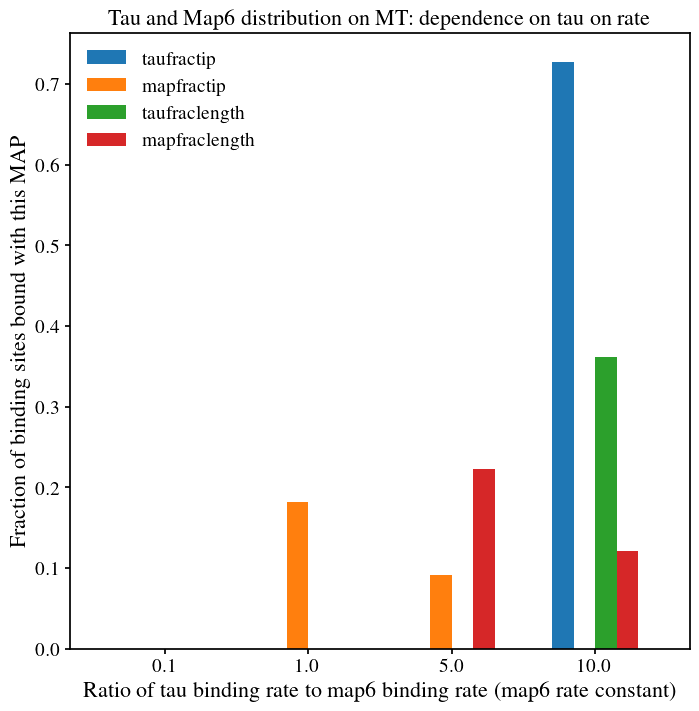

In [14]:
# make a grouped bar plot
# on the horizontal: ratio of tau binding rate to map6 binding rate
# on the vertical:
# 1. plus-end tau fraction (taufractip)
# 2. plus-end map6 fraction (mapfractip)
# 3. stable domain tau fraction (taufraclength)
# 4. stable domain map6 fraction (mapfraclength)

# define the group data and group labels (T0/M0)
group_data = {
    "taufractip": sim_avg_df["taufractip"],
    "mapfractip": sim_avg_df["mapfractip"],
    "taufraclength": sim_avg_df["taufraclength"],
    "mapfraclength": sim_avg_df["mapfraclength"],
}
group_labels = sim_avg_df.index

# define the colors
colors = ["orange", "blue", "grey", "green"]

# define the figure
fig, ax = plt.subplots()

# plot the data
fig, ax = grouped_bar_plot(fig, ax, group_data, group_labels, multiplier=-1/2)

# add a margin via xmargin to the x axis
ax.margins(x=0.1)

# set the labels
ax.set_xlabel(r"Ratio of tau binding rate to map6 binding rate (map6 rate constant)")
ax.set_ylabel(r"Fraction of binding sites bound with this MAP")
ax.set_title(r"Tau and Map6 distribution on MT: dependence on tau on rate")

# add a legend
ax.legend()

# save the figure
fig.savefig(figure_dir / r"binding_distribution_grouped")

## Individual Plotting

### Plot MT Length Over Time

In [15]:
# define a function to plot the mt length over time
# function should be similar to plot_clusters
def plot_mt_length(fig, ax, sim_dict: dict, sim_df: pd.DataFrame, colors: list = None):
    """Plots the microtubule length over time for each simulation

    Arguments:
        fig -- _description_
        ax -- _description_
        sim_dict -- _description_
        sim_df -- _description_

    Returns:
        _description_
    """

    # get a list of colors to iterate over
    if colors is None:
        colors = list(colormaps["tab10"].colors)

    # define a dictionary to color similar tau_ratios
    tau_ratio_dict = {}

    # iterate over each simulation in sim_dict and get the time and length array
    for sim_name in sim_dict.keys():
        # get the arrays
        mt_length_array = sim_dict[sim_name]["MTlength"]
        length_list = mt_length_array[:, 1]
        time_list = mt_length_array[:, 0]

        # get the tau binding rate T0 ratio
        tau_ratio = sim_df["T0/M0"][sim_name]

        # define the label
        label = r"$\tau_{\text{on}}=" + f"{tau_ratio}" + r"\ \text{map}_\text{on}$"

        # get a unique color for each tau ratio
        # if the color has been used, make the label None
        if tau_ratio not in tau_ratio_dict.keys():
            tau_ratio_dict[tau_ratio] = colors.pop(0)
        else:
            label = None

        # plot the length over time for this mt
        ax.plot(
            time_list,
            length_list,
            label=label,
            color=tau_ratio_dict[tau_ratio]
        )

    # set the axis limits
    # the x limit should be the final time plus the second time
    # this has the effect of showing an "even" value
    ax.set_xlim(0, time_list[-1] + time_list[1])

    # set the labels
    ax.set_xlabel(r"Time $\left[\qty{}{\second}\right]$")
    ax.set_ylabel(r"Microtubule length $\left[\qty{}{\micro\meter}\right]$")
    ax.set_title(r"Microtubule growth over time")

    # add a legend
    ax.legend()

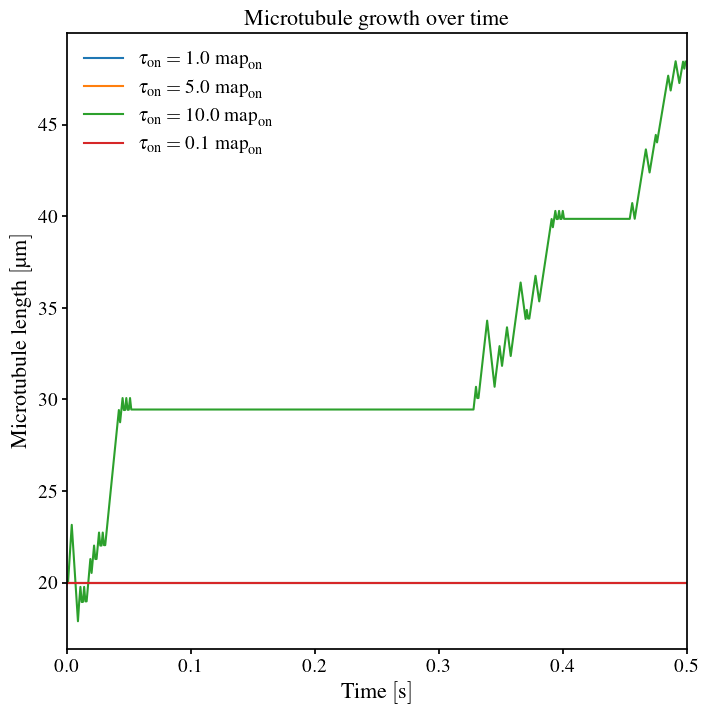

In [16]:
# plot the length of the mt over time
# define the figure
fig, ax = plt.subplots()

# plot the mt length over time
plot_mt_length(fig, ax, sim_dict, sim_df)

# save the figure
fig.savefig(figure_dir / r"mt_growth_over_time")

### Plot tau map6 Distribution

In [17]:
# define the name of the sim to plot
sim_name = list(sim_dict.keys())[2]
print(f"Plotting '{sim_name}'/{list(sim_dict.keys())}.")

Plotting 'Tausim_4_053124'/['Tausim_2_053124', 'Tausim_3_053124', 'Tausim_4_053124', 'Tausim_1_053124'].

In [18]:
# define a function to extract the distribution information
# should take inputs of name, time step, and sim dict
def extract_distribution(name: str, time_step: int, sim_dict: dict):
    """Extracts the distribution information from a simulation

    Arguments:
        name {str} -- name of the simulation in the sim_dict
        time_step {int} -- time step of the simulation
        sim_dict {dict} -- dictionary of simulation data

    Returns:
        tuple -- (time, length, mt_state_array, grid_spacing)
    """

    # extract some values
    time_value = sim_dict[name]["t"][time_step]
    length_value = sim_dict[name]["MTlength"][time_step][1]

    # get that row of MTgrid
    mt_state = sim_dict[name]["MTgrid"][time_step]

    # get the first index of -1 from mt_state, then remove all entries beyond
    # consider that there may be no entries of -1
    try:
        minus_one_index = np.where(mt_state == -1)[0][0]
        mt_state = mt_state[:minus_one_index]
    except IndexError:
        pass

    # calculate grid information
    binding_sites = len(mt_state)
    grid_spacing = length_value / (binding_sites - 1)
    grid_positions = np.linspace(0, length_value, binding_sites)

    # join grid_positions and mt_state as columns in a np array
    mt_state_array = np.column_stack((grid_positions, mt_state))

    # return
    return time_value, length_value, mt_state_array, grid_spacing

In [19]:
# define a function to extract the domain information
# function should call extract_distribution
def extract_sequences(name: str, time_step: int, sim_dict: dict):
    """Extracts the sequence information from a simulation

    Arguments:
        name {str} -- name of the simulation in the sim_dict
        time_step {int} -- time step of the simulation
        sim_dict {dict} -- dictionary of simulation data

    Returns:
        pd.DataFrame -- dataframe of sequence information
    """

    # extract the distribution information
    _, _, mt_state_array, _ = extract_distribution(name, time_step, sim_dict)

    # define the sequence dictionary
    sequence_dict = {
        "start_pos": [],
        "width": [],
        "end_pos": [],
        "center_pos": [],
        "num_proteins": [],
        "protein_type": []
    }

    # track the start position of the current sequence and protein type
    start_pos = mt_state_array[0][0]
    start_index = 0
    protein_type = mt_state_array[0][1]

    # iterate over the mt_state_array
    for i, (pos, protein) in enumerate(mt_state_array):
        # check if the protein type has changed or its the last entry
        if protein != protein_type or i == len(mt_state_array) - 1:
            # calculate the sequence width and center
            domain_width = pos - start_pos
            domain_center = start_pos + domain_width / 2

            # append the sequence to the sequence_dict
            sequence_dict["start_pos"].append(start_pos)
            sequence_dict["width"].append(domain_width)
            sequence_dict["end_pos"].append(pos)
            sequence_dict["center_pos"].append(domain_center)
            sequence_dict["num_proteins"].append(int(i - start_index))
            sequence_dict["protein_type"].append(int(protein_type))

            # update the start position and protein type
            start_pos = pos
            start_index = i
            protein_type = protein

    # convert the sequence_dict to a dataframe
    sequence_df = pd.DataFrame(sequence_dict)

    # return
    return sequence_df

In [20]:
# define a function to plot groups based on clusters
# should take input of fig, ax
# should not save the plot
# should take optional input of a color list
# should call extract_distribution and extract_sequence as needed
def plot_clusters(
    fig, ax,
    name: str,
    sim_dict: dict,
    time_step: int = -1,
    colors: list = None,
    invert_map6: bool = True,
    protein_points_size: int = 0,
    horizontal_line: bool = True,
    binding_ticks: bool = False,
    legend_loc: str = "upper left",
    yabs_max_override: int = None,
    ):
    """Plots the protein clusters along a microtubule

    Arguments:
        fig -- figure object
        ax -- axis object
        name {str} -- name of the simulation in the sim_dict
        sim_dict {dict} -- dictionary of simulation data

    Keyword Arguments:
        time_step {int} -- time step of the simulation (default: {-1})
        colors {list} -- list of colors for the protein types (default: {None})
        invert_map6 {bool} -- invert the map6 axis for readability (default: {True})
        protein_points_size {int} -- size of the protein points on the horizontal axis (default: {0})
        horizontal_line {bool} -- draw a horizontal line at y=0 (default: {True})
        binding_ticks {bool} -- show ticks for each binding site on the horizontal axis (default: {False})
        legend_loc {str} -- location of the legend (default: {"upper left"})
        yabs_max_override {int} -- override the y-axis maximum value (default: {None})
    """

    # extract the distribution information
    _, length_value, mt_state_array, grid_spacing = extract_distribution(name, time_step, sim_dict)

    # extract the sequence information
    # this was previously called the domain information
    sequence_df = extract_sequences(name, time_step, sim_dict)

    # get a list of colors
    if colors is None:
        colors = colormaps["tab10"].colors

    # define tau and map6 colors
    tau_color = colors[0]
    map6_color = colors[1]

    # use the sequence_df to plot the sequence information
    for (i, start_pos, width, end_pos, center_pos, num_proteins, protein_type) in sequence_df.itertuples():
        # skip protein_type 0
        if protein_type == 0: continue

        # use the protein type to determine the color
        if protein_type == 1: color = tau_color
        elif protein_type == 2: color = map6_color

        # get height_scale and check for map6 inversion
        height_scale = 1
        if protein_type == 2 and invert_map6:
            height_scale = -1

        # use a point with a horizontal error bar
        ax.errorbar(
            center_pos,
            num_proteins*height_scale,
            xerr=width / 2,
            fmt="o",
            color="black",
            markersize=0
        )

        # shade the region below the bar with no outline
        ax.fill_between(
            [start_pos, end_pos],
            0,
            num_proteins*height_scale,
            color=color,
            alpha=1,
            linewidth=0,
            zorder=0,
        )

    # plot each protein on the horizontal if protein points
    if protein_points_size != 0:
        for (pos, protein) in mt_state_array:
            # protein = 1 means tau
            # protein = 2 means map6
            # check that the protein value is not 0
            if protein == 0: continue

            # use the protein value to determine the color
            if protein == 1: color = tau_color
            elif protein == 2: color = map6_color

            # plot the protein as a dot with a black outline
            protein_pos = pos + grid_spacing/2
            ax.scatter(protein_pos, 0, color=color, s=protein_points_size, edgecolors="black", zorder=2)

    # plot a horizontal line at y=0
    # the line should be the length of the mt at the current time step
    # plot the line in the background
    if horizontal_line:
        # ax.axhline(0, color="black", zorder=1)
        ax.plot([0, length_value], [0, 0], color="black", zorder=1)

    # get the largest value on the y axis after plotting
    if yabs_max_override is not None:
        yabs_max = yabs_max_override
    else:
        yabs_max = abs(max(ax.get_ylim(), key=abs))

    # force largest value to be the next highest multiple of 5
    yabs_max = 5 * (yabs_max // 5 + 1)

    # set the y axis limits
    ax.set_ylim(ymin=-yabs_max, ymax=yabs_max)

    # relabel the y-axis in absolute value using a formatter
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{abs(x):.0f}"))

    # plot small vertical bars for each binding site
    # the vertical bars should be centered on y=0
    # they vertical bars should extend vertically just a small amount
    if binding_ticks:
        for pos in mt_state_array[:, 0]:
            # scale the height by the y-axis limit
            height = 2 * ax.get_ylim()[0] / 100
            ax.vlines(pos, -height, height, color="black")

    # set the xlim to (0, mt length at current time)
    ax.set_xlim(0, length_value)

    # set the labels
    ax.set_xlabel(r"Position along microtubule $\left[\qty{}{\micro\meter}\right]$")
    ax.set_ylabel(r"Number of proteins in uninterupted sequence")
    ax.set_title(r"Protein cluster distribution along microtubule")

    # add a legend with a label for map6 and tau using artists
    # the label should be a colored rectangle
    tau_label = plt.Rectangle((0, 0), 1, 1, fc=tau_color, edgecolor="black")
    map6_label = plt.Rectangle((0, 0), 1, 1, fc=map6_color, edgecolor="black")

    # define artists for the protein dots
    # include the outline
    tau_dot = plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=tau_color, markersize=10, markeredgewidth=1, markeredgecolor="black")
    map6_dot = plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=map6_color, markersize=10, markeredgewidth=1, markeredgecolor="black")

    # add legend to the upper-left depening on protein print status
    if protein_points_size != 0:
        ax.legend(
            [tau_label, tau_dot, map6_label, map6_dot],
            ["Tau Cluster", "Tau Protein", "Map6 Cluster", "Map6 Protein"],
            loc=legend_loc)
    else:
        ax.legend(
            [tau_label, map6_label],
            ["Tau Sequence", "Map6 Sequence"],
            loc=legend_loc)


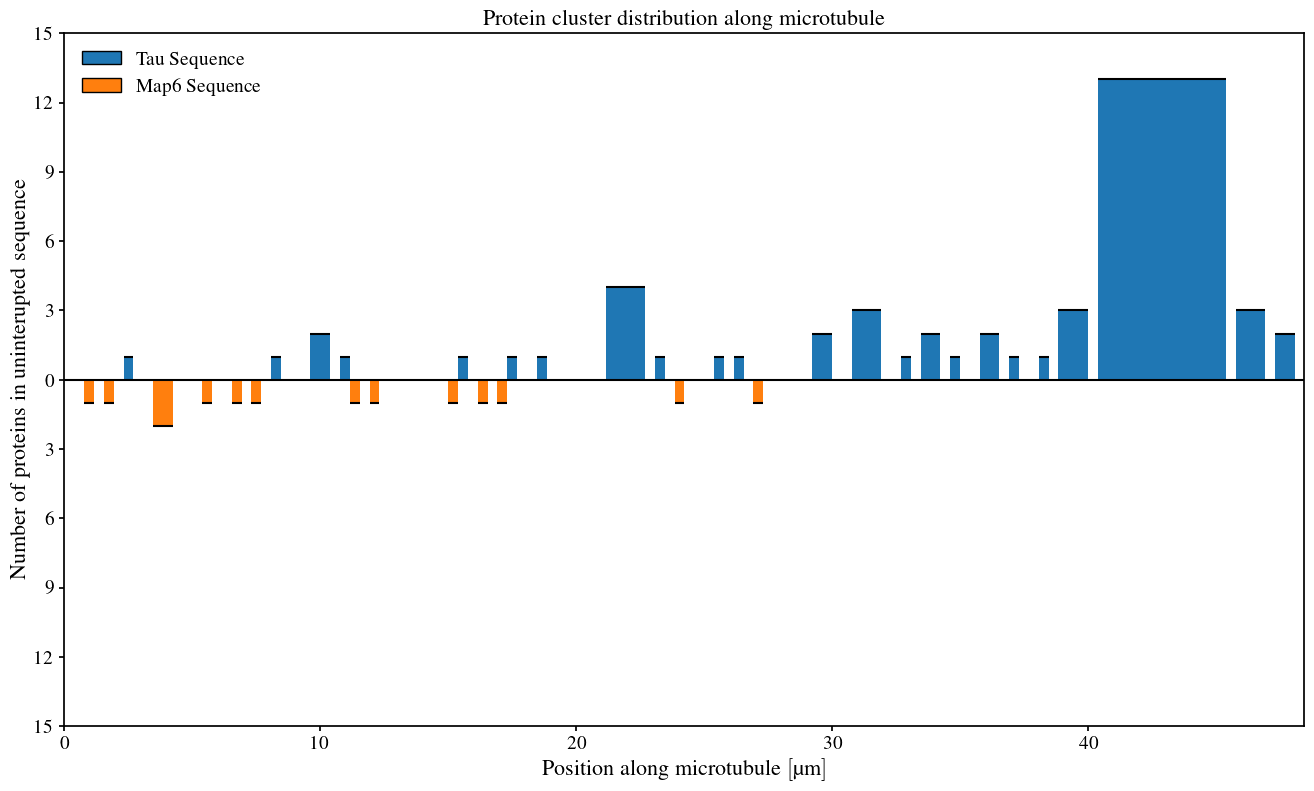

In [21]:
# plot the protein cluster distribution using the function
# define the figure
fig, ax = plt.subplots(figsize=(16, 9))

# plot the clusters
plot_clusters(fig, ax, name=sim_name, sim_dict=sim_dict, time_step=-1, protein_points_size=0, binding_ticks=False)

# save the figure
fig.savefig(figure_dir / r"protein_cluster_distribution")

#### Plot earlier time step

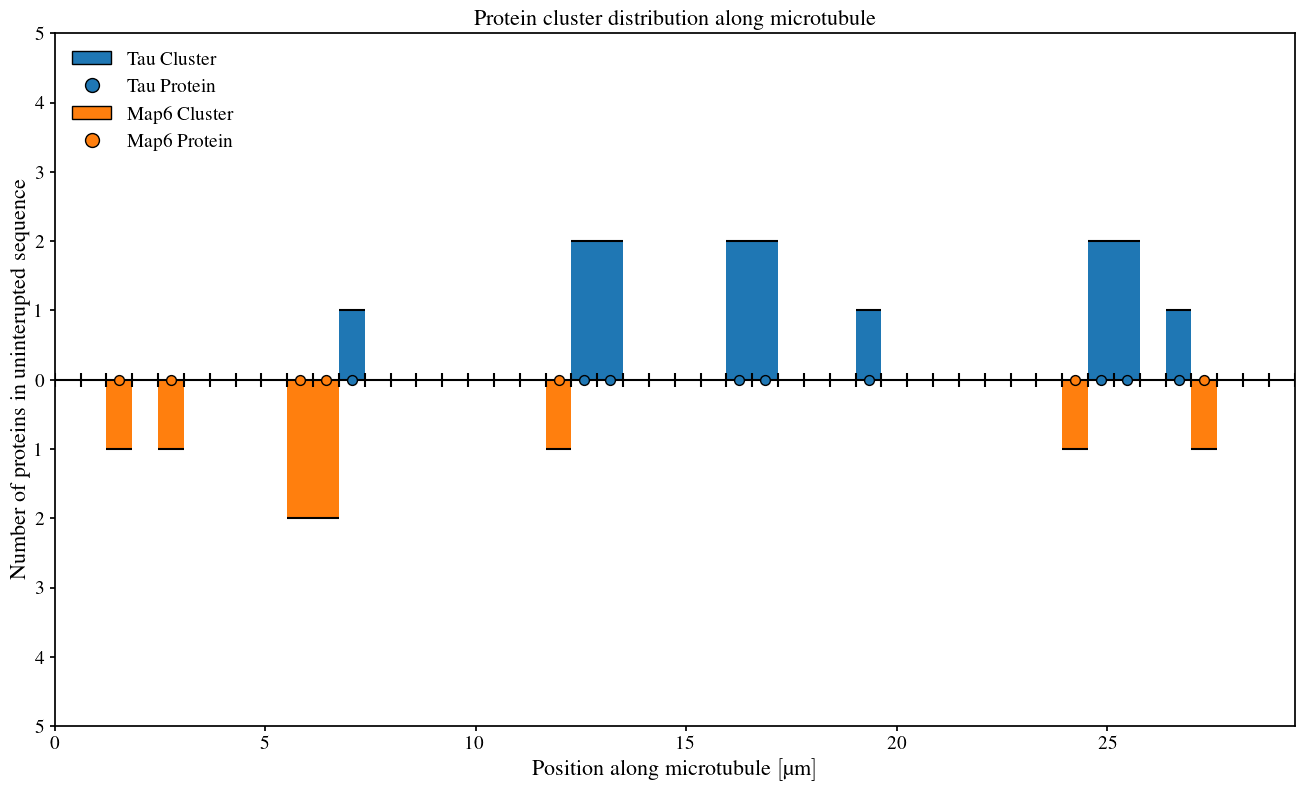

In [22]:
# plot the protein cluster distribution using the function
# define the figure
fig, ax = plt.subplots(figsize=(16, 9))

# plot the clusters
plot_clusters(fig, ax, name=sim_name, sim_dict=sim_dict, time_step=200, protein_points_size=50, binding_ticks=True)

# save the figure
fig.savefig(figure_dir / r"protein_cluster_distribution_explainer")

# Animations

## Configuration

In [23]:
# define the animation generation function
def create_protein_animation(save_path: Path, sim_name: str, sim_dict: dict, frame_rate: int = 60, anim_time: int = 10, overwrite: bool = False, protein_points_size: int = 0, binding_ticks: bool = False, override_yaxis: bool = True):
    """Creates an animation of the protein clusters along the microtubule

    Arguments:
        save_path {Path} -- path to save the animation
        sim_name {str} -- name of the simulation in the sim_dict
        sim_dict {dict} -- dictionary of simulation data

    Keyword Arguments:
        frame_rate {int} -- frame rate of the animation in frames per second (default: {60})
        anim_time {int} -- desired runtime of the animation in seconds (default: {10})
        overwrite {bool} -- whether to overwrite the save_path if it already exists (default: {False})
        protein_points_size {int} -- size of the protein points on the horizontal axis (default: {0})
        binding_ticks {bool} -- show ticks for each binding site on the horizontal axis (default: {False})
        override_yaxis {bool} -- override the y-axis maximum value (default: {True})
    """

    # validate the save path (check that it is a path and exists and is empty)
    # the save path could be a string or other pathlike but it will be recast
    if isinstance(save_path, str):
        save_path = Path(save_path)

    if not isinstance(save_path, Path):
        raise ValueError("save_path must be a Path object.")

    if save_path.exists() and not overwrite:
        raise FileExistsError(f"File '{save_path}' already exists. Set 'overwrite=True' to overwrite the file.")

    # validate the sim name
    if sim_name not in sim_dict.keys():
        raise ValueError(f"Simulation '{sim_name}' not found in sim_dict. Available simulations: {list(sim_dict.keys())}.")

    # get the frame count
    frame_count = anim_time * frame_rate

    # get time step information
    max_time_step = sim_dict[sim_name]["t"].shape[0]
    time_steps = np.linspace(0, max_time_step-1, frame_count, dtype=int)

    # generate an animation from the frames
    # get the max mt length for the simulation
    max_mt_length = sim_dict[sim_name]["MTlength"][:, 1].max()

    # get the largest cluster size
    # iterate over each time step and extract sequence information
    # then save the largest num_proteins
    max_protein_count = 0
    if override_yaxis:
        for time_step in time_steps:
            sequence_df = extract_sequences(sim_name, time_step, sim_dict)
            max_protein_count = max(max_protein_count, sequence_df["num_proteins"].max())

    # if the max_protein_count is 0 then set it to none to let the drawing function handle it
    if max_protein_count == 0:
        max_protein_count = None

    # define the figure
    fig, ax = plt.subplots(figsize=(16, 9), layout="constrained")
    # fig.tight_layout()

    # define the animation
    def animate(i):
        # plot the clusters
        ax.clear()
        plot_clusters(
            fig, ax,
            name=sim_name,
            sim_dict=sim_dict,
            time_step=time_steps[i],
            protein_points_size=protein_points_size,
            binding_ticks=binding_ticks,
            yabs_max_override=max_protein_count)

        # set the x-axis limits to the max mt length
        ax.set_xlim(0, max_mt_length)

        # add the frame number and time to the top center of the plot
        frame_time = sim_dict[sim_name]["t"][time_steps[i]]
        step_str = f"Step: {time_steps[i]+1}/{max_time_step}"
        time_str = r"Time: \qty{" + f"{frame_time:.2f}" + r"}{\second}"
        ax.text(0.5, 0.05,
                time_str + r"\(\qquad\qquad\)" + step_str,
                horizontalalignment="center",
                verticalalignment="center",
                transform=ax.transAxes)

    # calculate the time interval from desired runtime and
    # frame count [second / frame]
    interval = anim_time / frame_count
    # [millisecond / frame]
    scaled_interval = interval * 1000

    # create the animation
    with tqdm(total=frame_count, desc="Generating Frames") as pbar:
        def update(*args):
            pbar.update(1)

        # generate the animation function
        animation = FuncAnimation(
            fig,
            animate,
            frames=frame_count,
            interval=scaled_interval,
            repeat=False)

        # iterate over the animation function and save
        pbar.set_description(f"Generating Animation: '{save_path.name}'")
        animation.save(save_path, writer="ffmpeg", progress_callback=update, dpi=100)

    # close the figure
    plt.close(fig)

In [24]:
# define the frame directory and create it
frame_dir = Path("frames", data_dir.parts[-1])
os.makedirs(frame_dir, exist_ok=True)

# define the animation directory and create it
animation_dir = Path("animations", data_dir.parts[-1])
os.makedirs(animation_dir, exist_ok=True)

## Animation Generation

In [25]:
# define the sim name
sim_name = list(sim_dict.keys())[2]
print(f"Animating '{sim_name}'/{list(sim_dict.keys())}.")

# define the desired runtime in seconds
anim_time = 20
frame_rate = 60

# generate animations for different parameters
create_protein_animation(
    save_path=animation_dir / f"{sim_name}_animation_proteins.mp4",
    sim_name=sim_name,
    sim_dict=sim_dict,
    frame_rate=frame_rate,
    anim_time=anim_time,
    overwrite=True,
    protein_points_size=30,
    binding_ticks=True)


Animating 'Tausim_4_053124'/['Tausim_2_053124', 'Tausim_3_053124', 'Tausim_4_053124', 'Tausim_1_053124'].

Generating Animation: 'Tausim_4_053124_animation_proteins.mp4': 100%|██████████| 600/600 [11:19<00:00,  1.13s/it]
